# Projekt PZAP - Utjecaj zagađenja zraka na sreću stanovnika

## Izradio : Josip Koren 


# Uvod 

U današnjem svijetu, kvaliteta života stanovnika svake zemlje postaje sve važniji indikator društvenog napretka te države, ali trenutno sreća stanovnika se dobiva kao mjerilo bogatstva u toj državi kao i prilika u životu koje određena država nudi. Motivacija za ovaj projekt proizlazi iz radoznalosti ali i potrebe za razmumijevanjem kako zagađenje zraka može imati utjecaj na zdravlje ljudi i na kraju njihovu sreću u životu. Cilj projekta je prikazati da li države koje imaju najveći koeficijent sreće u **World Happiness Report-u 2024** to postižu uz čist zrak ili postoji više segmenata. Ova analiza moguće koorelacije između zagađenja zraka i ocjene sreće može pružiti uvid moguće nove uvide kako mjerimo općenitu sreću stanovnika.

# Opis implementacije

## Uvoženje biblioteka
U prvom koraku izrade aplikacije moramo uvesti potrebne biblioteke za rad, najbitnije od njih su "pandas" biblioteka s kojom manipuliramo podacima tako da ih uvezemo iz njihovog orifinalnog formata koji su u ovom slučaju csv i json, zatim ih pretvorimo u pandas-ov dataframe kako bi mogli lakse raditi sa njima. Json biblioteku koju koristimo za lakši rad sa json formatima. SQLalchemy biblioteku koju smo koristili kako bi podatke koje smo korisitli u csv i json spojili zajedno i stavili u bazu podataka i zatim tom bazom podataka manipulirali unutar REST API-ja kroz sql komande. Flask biblioteka nam je koristila kako bi lakse izradili REST API i prikazali nase podatke na njemu. Na kraju kada smo sredili podatke uvezli smo matplotlib biblioteku koja nam je posluzila za prikazivanje podataka na grafovima kako bi lakše došli do zaključka. 

## Uvoženje i čišćenje datasetova

Podatke smo prvo skinuli sa i dodali na jupyter notebook kako bi ih lakše koristili. Podatke smo uvozili pomoću Pandas biblioteke na naćin da smo za CSV datoteke koristili pd.read_csv("datoteka.csv") i za json datoteke pd.read_json("datoteka"), json datoteku smo dobili nakon što smo skinuli podatke sa API-jem. Nakon što smo učitali datoteku pretovrili smo je u Pandas-ov dataframe kako bi mogli vidjeti podatke i njima manipulirati. Prvu CSV datoteku koju sam koristio je "World-happiness-report-2024.csv" i nakon što smo je pretvorili u dataframe izbacio sam stupce koji mi nisu bili potrebni za moj zadatak. S obzirom da ta datoteka u sebi nije sadržavala sve potrebne podatke za korištenje API-ja kao što su koordinate glavnih gradova morao sam dodati još jednu CSV datoteku "concap.csv" koja u sebi sadrži države i njihove glavne gradove sa koordinatama. Prvobitni plan je bio koristiti biblioteku GeoPx ali zbog nestandardnih imena država unutar "World-happiness-report-2024.csv" nisam uspio dobiti željeni rezultat. Za svrhu aplikacije spojio sam te dvije CSV datoteke u jednu prema državama tako da dobijem za svaku državu njen glavni grad te koordinate koje su mi potrebne za dobivanje podataka iz API-ja. Datoteke sam spojio na način da sam ih pretovrio u dataframe te koristio slijedeći kod : `merged_df = pd.merge(df_proces, df_gradovi1[['Country name', 'CapitalName', 'CapitalLatitude', 'CapitalLongitude']], on='Country name', how='inner')` što nam govori da sam koristio pd.merge gdje sam ih spojio prema stupcu "Country name" odnosno prema državama. Za podatke o zagađenosti koristio sam OpenWeathermap Air Pollution API koji dohvaća podatke od tog dana prema koordinatama (širina engl. "latitude", dužina engl. "longitude") koje smo dobili u prošlom koraku sa dodavanjem druge CSV datoteke. Za API je bio potreban ključ za koji je bilo potrebno napraviti račun na njihovoj stranici te ograničenja za korištenje besplatne verziju da mogu prikupiti podatke od tog dana. Koristeći stupce "Latitude" i "Longitude" koje smo ubacili u link "http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={API key}" zajedno sa API ključem dobili smo podatke koje smo zatim spremili u json format. Dobiveni json format je bio dosta težak za raditi s njim stoga smo ga morali pretovriti u oblik u kojem je lakše raditi s njim :

```json

 "coord":
    50,
    50
  "list":
      "dt":1605182400,
      "main":
        "aqi":1
      "components":
        "co":201.94053649902344,
        "no":0.01877197064459324,
        "no2":0.7711350917816162,
        "o3":68.66455078125,
        "so2":0.6407499313354492,
        "pm2_5":0.5,
        "pm10":0.540438711643219,
        "nh3":0.12369127571582794
```
Nakon što smo ga izbacili sve podatke iz podskupina json podaci su izgledali ovako : 


```json
country"Finland"
capital"Helsinki"
latitude60.16666666666666
longitude24.933333
co263.69
no0
no23.56
o360.08
so20.67
pm2_50.77
pm101.48
nh30.12
```


Nakon što smo dobili format json-a s kojim je lakše raditi spojili smo json i CSV datoteke u jedan dataframe. Spojeni dataframe je imao duplikate stupaca koje smo morali maknuti zato što ih nismo koristili u daljnjoj obradi. Na kraju obrade podataka sam promijenio imena stupaca kako bi bili lakše čitljivi, promijenio sam imena sa engleskog na hrvatski za stupce za koje je to imalo smisla, za stupce koji u sebi koriste imena kemijskih tvari sam ostavio na originalnom imenu, zatim sam dodao dodatni stupac "id" koji sam koristio u REST API-u.

## SQLAlchemy baza podataka

Spojeni datframe u kojem se nalaze CSV podaci i API podaci u json formatu smo spremili u bazu podataka uz pomoć biblioteke "SQLAlchemy" koja u srži koristi sqlite. Prvo smo napravili url za bazu podataka i datoteku u kojoj će se ta baza spremati uz pomoć `db_url = "sqlite:///airpollution.db"`, naša datoteka će se zvati airpollution.db. Zatim smo napravili takozvanu "engine" funkciju koja služi kao potpora za spremanje i čitanje podataka iz tablice. Nakon toga smo morali kreirati samu tablicu i ubaciti podatke u nju to sam napravio pomoću Pandas funkcije to.sql koja prevodi dataframe u bazu podataka temeljenu na SQL-u `df_komb.to_sql("Sreca", engine, index=False, if_exists="replace")`, naša tablica se zove "Sreca" i u nju smo pospremili sve podatke iz spojenog dataframe-a.

## Rest API

Kreirali smo jednostavnu web aplikaciju Rest API uz biblioteku Flask sa mogućnostima dohvaćanja cjelokupnih podataka, dohvaćanja podataka po id-u i brisanja podataka po id-u. Ovaj dio koda omogućuje interakciju sa HTTP zahtjevima, dohvaćanje podataka funkcionira pomoću linka koji dan ispod koda ali za "DELETE" smo koristili biblioteku subprocess kako bi koristili curl i poslali DELETE zahtjev na HTTP.

## Vizualizacija grafova

Završni dio projekta je vizualiziranje podataka pomoću grafova, za tu svrhu sam koristio biblioteku "matplotlib" koja nam daje mogućnost stvaranje raznih grafova po našim potrebama. U mojem projektu sam prikazao koliko koja kemijska tvar ima utjecaj na sreću, zatim sam napravio grafove koji prikazuju ovisnot srece o pojedinoj tvari te srecu po regijama i koja regija ima najviše štetnih tvari u svom zraku. Grafovi koje sam napravio nisu objektivni zato što iz dana u dan kada pokrenemo kod i povučemo nove podatke grafovi će se promijeniti. Slika grafova je promijenjiva s obzirom na to kada je pokrenut kod.

# Prikaz rada aplikacije (Rest API)

### Prikaz svih podataka u REST API
![Pirkaz svih podataka u REST API](rest_api_podaci.png)

### Brisanje podataka u REST API (u primjeru je obrisan treci po redu u prvoj slici je prikazan)
![Brisanje podataka](rest_api_obrisi.png)

### Prikaz podataka po ID-u (u primjeru je prikazan ID=56)
![Prikaz pojedinih podataka u REST API](rest_api_trazi.png)

# Kritički osvrt

Projekt pruža korisne informacije o potencijalnom utjecaju zagađenja zraka na sreću ljudi, ali dolazi s određenim izazovima. Praktična izvedivost analize ovisi o točnosti i ažurnosti prikupljenih podataka, budući da subjektivni faktori poput kulturnih razlika, socioekonomskih uvjeta i individualnih percepcija također imaju značajan utjecaj na sreću. Nadalje, podaci o zagađenju zraka često variraju tijekom dana i ovise o lokalnim uvjetima, što može otežati precizno povezivanje s godišnjim podacima o sreći. Unatoč tim izazovima, ova analiza može poslužiti kao vrijedan alat za podizanje svijesti o problemu zagađenja i njegovom potencijalnom utjecaju na kvalitetu života, potičući daljnja istraživanja i primjenu mjera za poboljšanje okoliša. Ova analiza korelacije između zagađenosti zraka bi bila korisna kada bi imali puno veći opseg podataka nego što je prikazano ovdje kada bi mogli uzeti kroz cijelu godinu svaki dan podatke i njih analizirati i uzeti nekakvu sredinu vjerujem da bi analiza grafova bila puno različitija nego što je ovdje prikazano. Sastav zraka se mijenja iz dana u dan i tako je teško samo iz podataka jednog dana vidjeti kako bi zagađenost utjecala na sreću stanovnika.

# Zaključak

Analiza utjecaja zagađenja zraka na sreću stanovnika pruža zanimljiv uvid u međusobnu povezanost okolišnih i društvenih faktora. Dobiveni rezultati mogu pomoći u donošenju politika usmjerenih na smanjenje zagađenja i poboljšanje kvalitete života. Iako postoje određena ograničenja u točnosti podataka i njihovoj interpretaciji, projekt naglašava važnost integracije ekoloških pokazatelja u procjenu društvene dobrobiti. Budući rad na ovom području mogao bi uključivati dublju analizu pojedinačnih faktora i implementaciju prediktivnih modela kako bi se pružile preciznije preporuke za održivi razvoj. Zaključujem da je ovo veoma zanimljiv pristup traženja novih faktora koji bi uključivali općenitu sreću stanovnika ali za bolju analizu je potrebno jako puno podataka koje bi trebali skupljati iz dana u dan.

# Literatura
[1]“World Happiness Report- 2024,” www.kaggle.com. [https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated](https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated) (Pristupano 10.1.2025) \
[2]Grecnik, “World capitals gps,” Kaggle.com, 2019. [https://www.kaggle.com/datasets/nikitagrec/world-capitals-gps/data](https://www.kaggle.com/datasets/nikitagrec/world-capitals-gps/data) (Pristupano 11.1.2025). \
[3]“Air Pollution - OpenWeatherMap,” openweathermap.org. [https://openweathermap.org/api/air-pollution](https://openweathermap.org/api/air-pollution) \
[4]“Python | Build a REST API using Flask,” GeeksforGeeks, Jul. 29, 2019. https://www.geeksforgeeks.org/python-build-a-rest-api-using-flask/ \
[5]Philipp Acsany, “Python REST APIs With Flask, Connexion, and SQLAlchemy – Part 2,” Realpython.com, Nov. 16, 2022. https://realpython.com/flask-connexion-rest-api-part-2/ (pristupljeno 12.1.2025).
[6]GeeksforGeeks, “Connecting Pandas to a Database with SQLAlchemy,” GeeksforGeeks, Jan. 24, 2022. https://www.geeksforgeeks.org/connecting-pandas-to-a-database-with-sqlalchemy/ (pristupljeno 12.1.2025).
[7]W3Schools, “Matplotlib Tutorial,” www.w3schools.com. https://www.w3schools.com/python/matplotlib_intro.asp

# Kod projekta

In [1]:
import pandas as pd
import json
from flask import Flask, jsonify
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

Stvaranje dataframe-a iz datoteke 

In [2]:
csv = "World-happiness-report-2024.csv"

df = pd.read_csv(csv)
df.head()

,Country name,Regional indicator,Ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082
1,Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881
2,Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050
3,Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658
4,Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298


In [5]:
df.columns

Index(['Country name', 'Regional indicator', 'Ladder score', 'upperwhisker',
       'lowerwhisker', 'Log GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Dystopia + residual'],
      dtype='object')

Brisanje nepotrebnih stupaca iz DataFrame-a

In [7]:
df_proces = df.drop(columns=["Log GDP per capita","Social support","Freedom to make life choices","Generosity", "Perceptions of corruption", "Dystopia + residual","upperwhisker","lowerwhisker"])
df_proces.head()

,Country name,Regional indicator,Ladder score,Healthy life expectancy
0,Finland,Western Europe,7.741,0.695
1,Denmark,Western Europe,7.583,0.699
2,Iceland,Western Europe,7.525,0.718
3,Sweden,Western Europe,7.344,0.724
4,Israel,Middle East and North Africa,7.341,0.740


Datoteka koja sadrži gradove, države i koordinate tih gradova

In [9]:
gradovi = "concap.csv"
df_gradovi = pd.read_csv(gradovi)
df_gradovi.head()

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude,CountryCode,ContinentName
0,Somaliland,Hargeisa,9.550000,44.050000,NaN,Africa
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000,GS,Antarctica
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667,TF,Antarctica
3,Palestine,Jerusalem,31.766667,35.233333,PS,Asia
4,Aland Islands,Mariehamn,60.116667,19.900000,AX,Europe


Brisanje nepotrebnih stupaca

In [11]:
df_gradovi1=df_gradovi.drop(columns=["CountryCode","ContinentName"])

In [13]:
df_gradovi1.head()

,CountryName,CapitalName,CapitalLatitude,CapitalLongitude
0,Somaliland,Hargeisa,9.550000,44.050000
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667
3,Palestine,Jerusalem,31.766667,35.233333
4,Aland Islands,Mariehamn,60.116667,19.900000


Spajanje dva DataFrame u jedan preko stupaca "CountryName"

In [106]:
df_gradovi1.rename(columns={'CountryName': 'Country name'}, inplace=True)

merged_df = pd.merge(df_proces, df_gradovi1[['Country name', 'CapitalName', 'CapitalLatitude', 'CapitalLongitude']], 
                     on='Country name', how='inner')
merged_df.to_csv('merged_capitals.csv', index=False)

print("Podaci su spremljeni u 'merged_capitals.csv'.")


Podaci su spremljeni u 'merged_capitals.csv'.


In [17]:
df_gradovi1.head(10)

,Country name,CapitalName,CapitalLatitude,CapitalLongitude
0,Somaliland,Hargeisa,9.550000,44.050000
1,South Georgia and South Sandwich Islands,King Edward Point,-54.283333,-36.500000
2,French Southern and Antarctic Lands,Port-aux-Français,-49.350000,70.216667
3,Palestine,Jerusalem,31.766667,35.233333
4,Aland Islands,Mariehamn,60.116667,19.900000
5,Nauru,Yaren,-0.547700,166.920867
6,Saint Martin,Marigot,18.073100,-63.082200
7,Tokelau,Atafu,-9.166667,-171.833333
8,Western Sahara,El-Aaiún,27.153611,-13.203333
9,Afghanistan,Kabul,34.516667,69.183333


## OpenWeatherMap API

Dohvaćanje podataka preko API-a sa bibliotekom request i spremanje tih istih podataka u json format datoteku.

In [19]:
import requests


API_KEY = 'b0b003be894eab5717eb0839bf413785'


df = pd.read_csv('merged_capitals.csv')


def get_air_pollution_data(lat, lon):
    url = f'http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={API_KEY}'
    response = requests.get(url)
    return response.json()


structured_data = []

for index, row in df.iterrows():
    country = row['Country name']  
    capital = row['CapitalName']      
    lat = row['CapitalLatitude']         
    lon = row['CapitalLongitude']        
    
    air_pollution = get_air_pollution_data(lat, lon)
    
    city_data = {
        'country': country,
        'capital': capital,
        'latitude': lat,
        'longitude': lon,
        'air_pollution_data': air_pollution
    }
    
    structured_data.append(city_data)

with open('air_pollution_data.json', 'w') as json_file:
    json.dump(structured_data, json_file, indent=4)

print("Uspješno spremljeno u air_pollution_data.json")


Uspješno spremljeno u air_pollution_data.json


### Uređivanje json datoteke

In [21]:


with open('air_pollution_data.json', 'r') as json_file:
    data = json.load(json_file)


for entry in data:
    if 'air_pollution_data' in entry:
        pollution_data = entry['air_pollution_data']
        

        if 'list' in pollution_data and len(pollution_data['list']) > 0:
            components = pollution_data['list'][0].get('components', {})
            
            for key, value in components.items():
                entry[key] = value
        
        del entry['air_pollution_data']

with open('simplified_air_pollution_data.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

print("Uspješno spremljeno u simplified_air_pollution_data.json")


Uspješno spremljeno u simplified_air_pollution_data.json


In [23]:
json = "simplified_air_pollution_data.json"
df_json=pd.read_json(json)
df_json.head()

,country,capital,latitude,longitude,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Finland,Helsinki,60.166667,24.933333,263.69,0.00,3.56,60.08,0.67,0.77,1.48,0.12
1,Denmark,Copenhagen,55.666667,12.583333,283.72,0.00,8.05,61.51,0.82,3.42,3.86,0.25
2,Iceland,Reykjavik,64.150000,-21.950000,230.31,0.00,0.20,85.12,0.69,0.50,0.50,0.08
3,Sweden,Stockholm,59.333333,18.050000,337.12,0.01,9.08,47.92,3.58,1.14,1.42,0.29
4,Israel,Jerusalem,31.766667,35.233333,363.83,2.43,75.40,6.35,6.97,13.92,16.28,0.05


In [25]:
csv_grad="merged_capitals.csv"
df_gotovi=pd.read_csv(csv_grad)
df_gotovi.head()

,Country name,Regional indicator,Ladder score,Healthy life expectancy,CapitalName,CapitalLatitude,CapitalLongitude
0,Finland,Western Europe,7.741,0.695,Helsinki,60.166667,24.933333
1,Denmark,Western Europe,7.583,0.699,Copenhagen,55.666667,12.583333
2,Iceland,Western Europe,7.525,0.718,Reykjavik,64.150000,-21.950000
3,Sweden,Western Europe,7.344,0.724,Stockholm,59.333333,18.050000
4,Israel,Middle East and North Africa,7.341,0.740,Jerusalem,31.766667,35.233333


### Spajanje json-a i csv-a

In [27]:
df_komb=pd.merge(df_gotovi,df_json,how='left',left_on='Country name',right_on='country')
df_komb

,Country name,Regional indicator,Ladder score,Healthy life expectancy,CapitalName,CapitalLatitude,CapitalLongitude,country,capital,latitude,longitude,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Finland,Western Europe,7.741,0.695,Helsinki,60.166667,24.933333,Finland,Helsinki,60.166667,24.933333,263.69,0.00,3.56,60.08,0.67,0.77,1.48,0.12
1,Denmark,Western Europe,7.583,0.699,Copenhagen,55.666667,12.583333,Denmark,Copenhagen,55.666667,12.583333,283.72,0.00,8.05,61.51,0.82,3.42,3.86,0.25
2,Iceland,Western Europe,7.525,0.718,Reykjavik,64.150000,-21.950000,Iceland,Reykjavik,64.150000,-21.950000,230.31,0.00,0.20,85.12,0.69,0.50,0.50,0.08
3,Sweden,Western Europe,7.344,0.724,Stockholm,59.333333,18.050000,Sweden,Stockholm,59.333333,18.050000,337.12,0.01,9.08,47.92,3.58,1.14,1.42,0.29
4,Israel,Middle East and North Africa,7.341,0.740,Jerusalem,31.766667,35.233333,Israel,Jerusalem,31.766667,35.233333,363.83,2.43,75.40,6.35,6.97,13.92,16.28,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Zimbabwe,Sub-Saharan Africa,3.341,0.232,Harare,-17.816667,31.033333,Zimbabwe,Harare,-17.816667,31.033333,340.46,0.05,4.33,13.95,5.42,8.15,10.28,1.30
128,Sierra Leone,Sub-Saharan Africa,3.245,0.253,Freetown,8.483333,-13.233333,Sierra Leone,Freetown,8.483333,-13.233333,216.96,0.00,0.29,73.67,0.38,52.01,198.56,0.11
129,Lesotho,Sub-Saharan Africa,3.186,0.000,Maseru,-29.316667,27.483333,Lesotho,Maseru,-29.316667,27.483333,367.17,0.00,3.81,36.12,0.86,11.44,23.63,2.76
130,Lebanon,Middle East and North Africa,2.707,0.556,Beirut,33.866667,35.500000,Lebanon,Beirut,33.866667,35.500000,343.80,0.00,12.34,75.82,20.74,5.70,7.26,0.91


In [29]:
df_komb.columns

Index(['Country name', 'Regional indicator', 'Ladder score',
       'Healthy life expectancy', 'CapitalName', 'CapitalLatitude',
       'CapitalLongitude', 'country', 'capital', 'latitude', 'longitude', 'co',
       'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3'],
      dtype='object')

### Uređivanje spojenog DataFrame-a

In [31]:
df_komb=df_komb.drop(columns=["CapitalLatitude","CapitalLongitude","latitude","longitude","country","capital",])

df_komb

,Country name,Regional indicator,Ladder score,Healthy life expectancy,CapitalName,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,Finland,Western Europe,7.741,0.695,Helsinki,263.69,0.00,3.56,60.08,0.67,0.77,1.48,0.12
1,Denmark,Western Europe,7.583,0.699,Copenhagen,283.72,0.00,8.05,61.51,0.82,3.42,3.86,0.25
2,Iceland,Western Europe,7.525,0.718,Reykjavik,230.31,0.00,0.20,85.12,0.69,0.50,0.50,0.08
3,Sweden,Western Europe,7.344,0.724,Stockholm,337.12,0.01,9.08,47.92,3.58,1.14,1.42,0.29
4,Israel,Middle East and North Africa,7.341,0.740,Jerusalem,363.83,2.43,75.40,6.35,6.97,13.92,16.28,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Zimbabwe,Sub-Saharan Africa,3.341,0.232,Harare,340.46,0.05,4.33,13.95,5.42,8.15,10.28,1.30
128,Sierra Leone,Sub-Saharan Africa,3.245,0.253,Freetown,216.96,0.00,0.29,73.67,0.38,52.01,198.56,0.11
129,Lesotho,Sub-Saharan Africa,3.186,0.000,Maseru,367.17,0.00,3.81,36.12,0.86,11.44,23.63,2.76
130,Lebanon,Middle East and North Africa,2.707,0.556,Beirut,343.80,0.00,12.34,75.82,20.74,5.70,7.26,0.91


In [33]:
novi_stupci={"Country name":"Drzava","Regional indicator":"Regija","Ladder score":"Ocjena srece","Healthy life expectancy":"Zivotni vijek","CapitalName":"Glavni grad","co":"Carbon monoxide","no":"Nitrogen monoxide","no2":"Nitrogen dioxide","o3":"Ozone","so2":"Sulphur dioxide","pm2_5":"Fine particles matter","pm10":"Coarse particulate matter","nh3":"Ammonia"}
df_komb.rename(columns=novi_stupci,inplace=True)
df_komb['id'] = range(1, len(df_komb) + 1)
df_komb

,Drzava,Regija,Ocjena srece,Zivotni vijek,Glavni grad,Carbon monoxide,Nitrogen monoxide,Nitrogen dioxide,Ozone,Sulphur dioxide,Fine particles matter,Coarse particulate matter,Ammonia,id
0,Finland,Western Europe,7.741,0.695,Helsinki,263.69,0.00,3.56,60.08,0.67,0.77,1.48,0.12,1
1,Denmark,Western Europe,7.583,0.699,Copenhagen,283.72,0.00,8.05,61.51,0.82,3.42,3.86,0.25,2
2,Iceland,Western Europe,7.525,0.718,Reykjavik,230.31,0.00,0.20,85.12,0.69,0.50,0.50,0.08,3
3,Sweden,Western Europe,7.344,0.724,Stockholm,337.12,0.01,9.08,47.92,3.58,1.14,1.42,0.29,4
4,Israel,Middle East and North Africa,7.341,0.740,Jerusalem,363.83,2.43,75.40,6.35,6.97,13.92,16.28,0.05,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Zimbabwe,Sub-Saharan Africa,3.341,0.232,Harare,340.46,0.05,4.33,13.95,5.42,8.15,10.28,1.30,128
128,Sierra Leone,Sub-Saharan Africa,3.245,0.253,Freetown,216.96,0.00,0.29,73.67,0.38,52.01,198.56,0.11,129
129,Lesotho,Sub-Saharan Africa,3.186,0.000,Maseru,367.17,0.00,3.81,36.12,0.86,11.44,23.63,2.76,130
130,Lebanon,Middle East and North Africa,2.707,0.556,Beirut,343.80,0.00,12.34,75.82,20.74,5.70,7.26,0.91,131


In [35]:
df_komb.columns

Index(['Drzava', 'Regija', 'Ocjena srece', 'Zivotni vijek', 'Glavni grad',
       'Carbon monoxide', 'Nitrogen monoxide', 'Nitrogen dioxide', 'Ozone',
       'Sulphur dioxide', 'Fine particles matter', 'Coarse particulate matter',
       'Ammonia', 'id'],
      dtype='object')

### Baza podataka SQLAlchemy

In [37]:
db_url="sqlite:///airpollution.db"
engine=create_engine(db_url)
df_komb.to_sql("Sreca",engine,index=False,if_exists="replace")
print("Uneseno")

Uneseno


Preko SQL upita dohhvaćamo sve podatke iz baze podataka

In [39]:
df_baza = pd.read_sql("SELECT * FROM Sreca", engine)
df_baza

,Drzava,Regija,Ocjena srece,Zivotni vijek,Glavni grad,Carbon monoxide,Nitrogen monoxide,Nitrogen dioxide,Ozone,Sulphur dioxide,Fine particles matter,Coarse particulate matter,Ammonia,id
0,Finland,Western Europe,7.741,0.695,Helsinki,263.69,0.00,3.56,60.08,0.67,0.77,1.48,0.12,1
1,Denmark,Western Europe,7.583,0.699,Copenhagen,283.72,0.00,8.05,61.51,0.82,3.42,3.86,0.25,2
2,Iceland,Western Europe,7.525,0.718,Reykjavik,230.31,0.00,0.20,85.12,0.69,0.50,0.50,0.08,3
3,Sweden,Western Europe,7.344,0.724,Stockholm,337.12,0.01,9.08,47.92,3.58,1.14,1.42,0.29,4
4,Israel,Middle East and North Africa,7.341,0.740,Jerusalem,363.83,2.43,75.40,6.35,6.97,13.92,16.28,0.05,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Zimbabwe,Sub-Saharan Africa,3.341,0.232,Harare,340.46,0.05,4.33,13.95,5.42,8.15,10.28,1.30,128
128,Sierra Leone,Sub-Saharan Africa,3.245,0.253,Freetown,216.96,0.00,0.29,73.67,0.38,52.01,198.56,0.11,129
129,Lesotho,Sub-Saharan Africa,3.186,0.000,Maseru,367.17,0.00,3.81,36.12,0.86,11.44,23.63,2.76,130
130,Lebanon,Middle East and North Africa,2.707,0.556,Beirut,343.80,0.00,12.34,75.82,20.74,5.70,7.26,0.91,131


## Rest API - Flask

Rest API smo pokrenuli sa threding bibliotekom kako bi ga odvojili da se pokreće na zasebnoj dretvi da ne zauzima dretvu koja pokreće ostale ćelije unutar jupyter notebooka. Alternativni način da se ovo napravi bi bio preko python skripte koja bi se pokretala odvojeno od jupyter notebooka. Glavne funckije su endpointi preko kojih komuniciramo sa Rest API-jem, to su /podaci za dohvaćanje svih podataka, /trazi/<int:id> s kojim dohvaćamo podatke po "id", /obrisi/<int:id> s kojim brisemo podatke po id-u. Ove operacije se izvode preko SQL upita tako da uspostavimo konekciju sa bazom, upisemo sql upit te "commitamo" i tako izvršimo željenu komandu.

In [49]:
import threading
import time
from flask import Flask, Response, request
from sqlalchemy import create_engine, MetaData, Table
import json
import pandas as pd

app = Flask(__name__)

db_url = "sqlite:///airpollution.db"
engine = create_engine(db_url)

metadata = MetaData()
sreca_table = Table('Sreca', metadata, autoload_with=engine)

@app.route('/podaci', methods=['GET'])
def pribavi_podatke():
    df_db = pd.read_sql('Sreca', engine)
    
    columns_order = [
        "Drzava", "Regija", "Ocjena srece", "Zivotni vijek", "Glavni grad", 
        "Carbon monoxide", "Nitrogen monoxide", "Nitrogen dioxide", "Ozone", 
        "Sulphur dioxide", "Fine particles matter", "Coarse particulate matter", 
        "Ammonia", "id"
    ]
    
    data_list_ordered = df_db[columns_order].to_dict(orient='records')

    response = Response(json.dumps({'data': data_list_ordered}, indent=2), content_type='application/json; charset=utf-8')
    return response

@app.route('/trazi/<int:id>', methods=['GET'])
def get_record_by_id(id):
    df_baza = pd.read_sql(f"SELECT * FROM Sreca WHERE id = {id}", engine)
    
    if not df_baza.empty:
        record = df_baza.to_dict(orient='records')[0]
        response = Response(json.dumps(record, indent=2), content_type='application/json; charset=utf-8')
        return response
    else:
        return Response(json.dumps({"message": "Pogreška podatak ne postoji"}), status=404, content_type='application/json')


from sqlalchemy import text

@app.route('/obrisi/<int:id>', methods=['DELETE'])
def delete_record(id):
    query = text("DELETE FROM Sreca WHERE id = :id")
    
    with engine.connect() as connection:
        result = connection.execute(query, {"id": id})
        connection.commit() 
    
    if result.rowcount > 0:
        return Response(json.dumps({"message": "Uspješno"}), status=200, content_type='application/json')
    else:
        return Response(json.dumps({"message": "nije pronađen id"}), status=404, content_type='application/json')

def run_flask():
    app.run(debug=True, use_reloader=False)

flask_thread = threading.Thread(target=run_flask, daemon=True)
flask_thread.start()

time.sleep(2)

print("Rest api je pokrenut")


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Rest api je pokrenut


# API pregled podataka

Api podaci se mogu pogledati nakon sto se pokrene program na adresama : 

Svi podaci [http://127.0.0.1:5000/podaci](http://127.0.0.1:5000/podaci) \
Specifični podaci preko ID-a [http://127.0.0.1:5000/trazi/56](http://127.0.0.1:5000/trazi/56) 


Id na kraju se može promijeniti unutar URL-a tu su dani primjeri

Delete se izvršava preko curl-a uz pomoć subprocess biblioteke.

In [125]:
import subprocess

id = 59
url = f"http://127.0.0.1:5000/obrisi/{id}"

process = subprocess.Popen(
    ["curl", "-X", "DELETE", url],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

stdout, stderr = process.communicate()

print("Response:", stdout.decode('utf-8'))
print("Error:", stderr.decode('utf-8')) if stderr else None


127.0.0.1 - - [25/Jan/2025 01:20:54] "DELETE /obrisi/59 HTTP/1.1" 200 -


Response: {"message": "Record deleted successfully"}
Error:   % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    42  100    42    0     0   3068      0 --:--:-- --:--:-- --:--:--  3230



# Grafovi

## Graf 1

U ovom grafu cilj je bio prikazati koliko utjecaja koja tvar u zraku ima na sreću

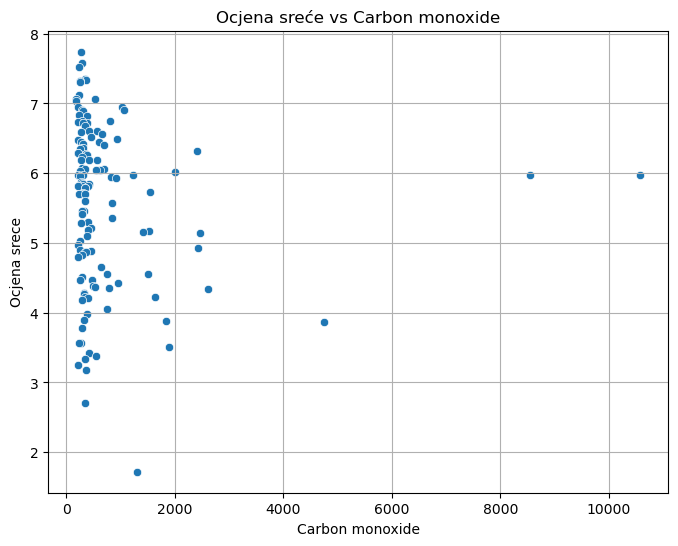

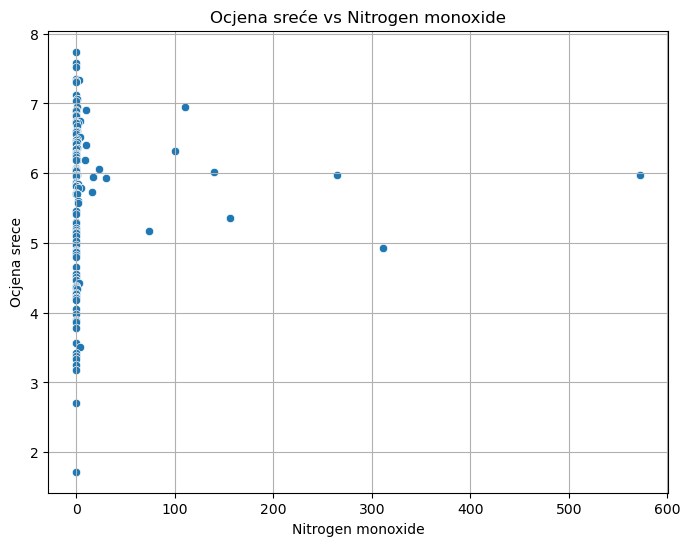

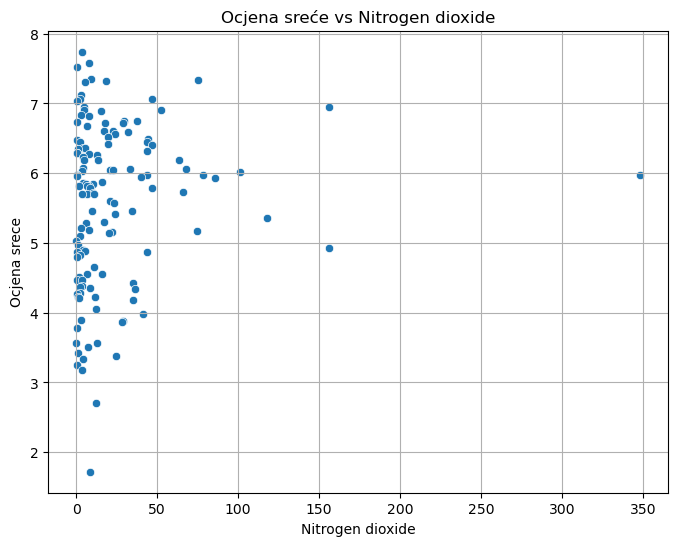

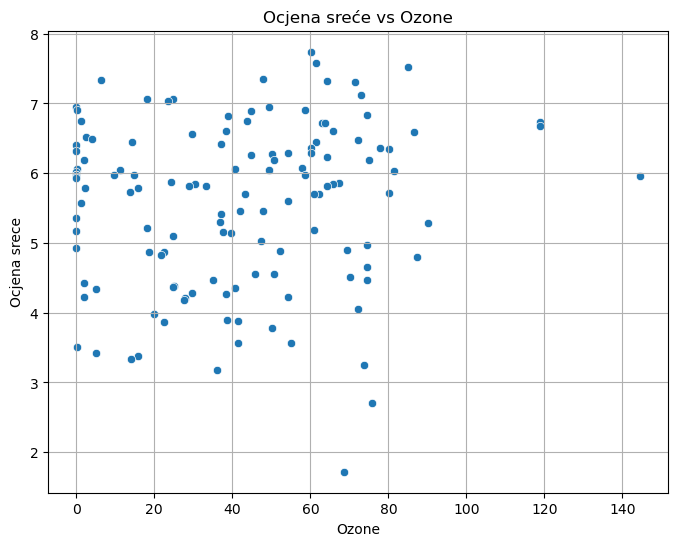

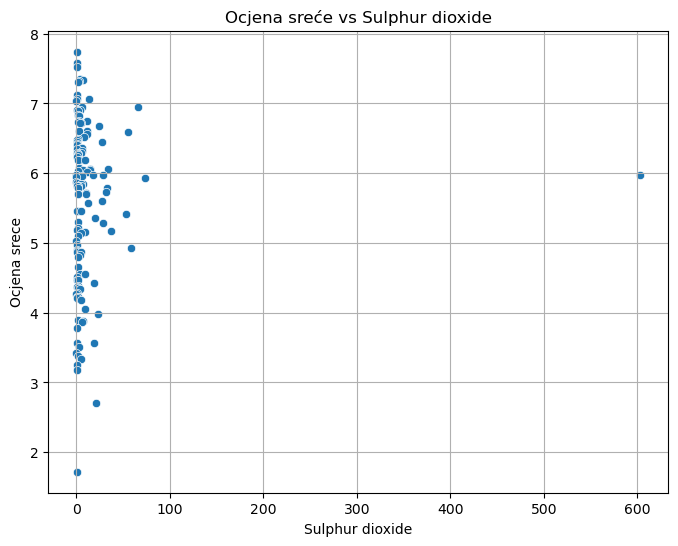

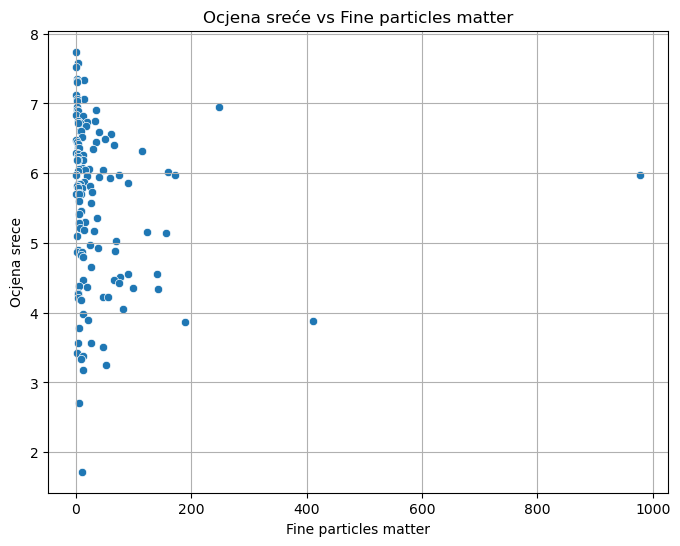

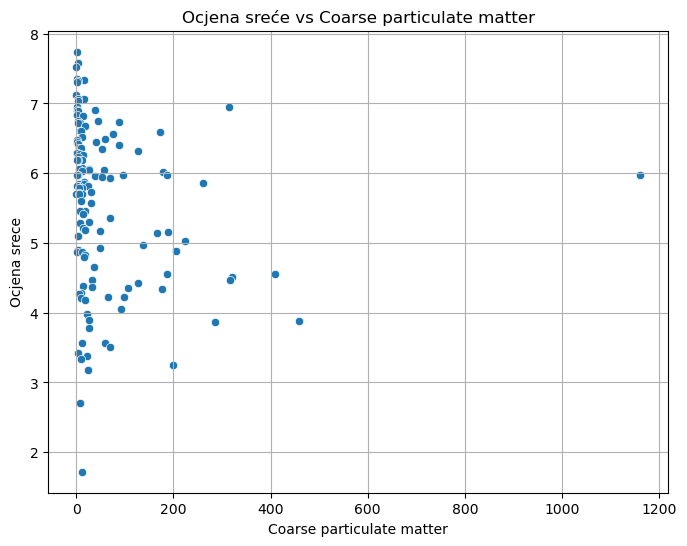

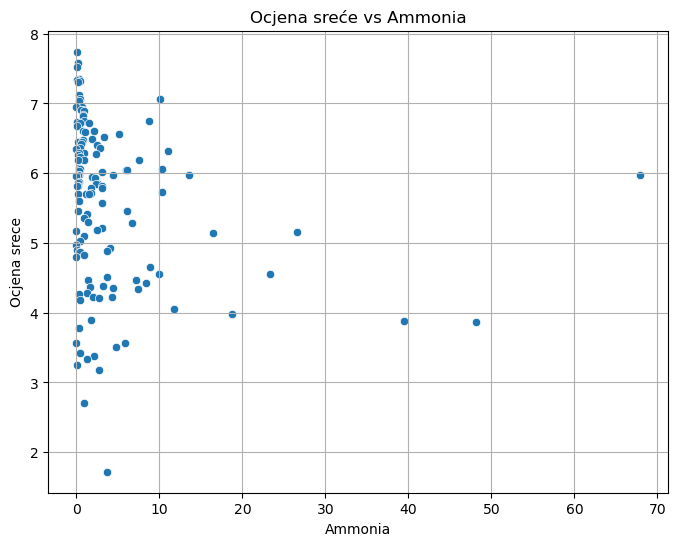

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pollutants = ['Carbon monoxide', 'Nitrogen monoxide', 'Nitrogen dioxide', 
              'Ozone', 'Sulphur dioxide', 'Fine particles matter', 
              'Coarse particulate matter', 'Ammonia']

for pollutant in pollutants:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_baza[pollutant], y=df_baza['Ocjena srece'])
    plt.title(f'Ocjena sreće vs {pollutant}')
    plt.xlabel(pollutant)
    plt.ylabel('Ocjena srece')
    plt.grid(True)
    plt.show()


## Graf 2

Tu prikazujemo koliku težinu imaju štetne tvari na ocjenu sreće

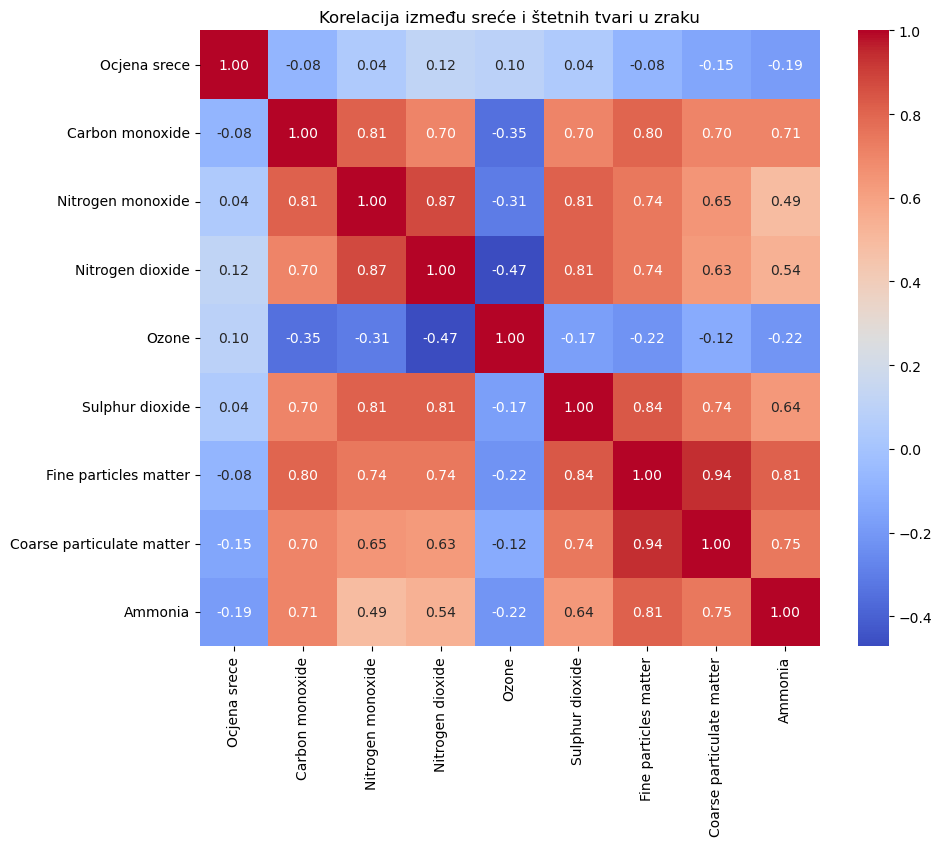

In [131]:
correlation_matrix = df_baza[['Ocjena srece'] + pollutants].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelacija između sreće i štetnih tvari u zraku')
plt.show()

# Graf 3 

Tu prikazujemo prosječnu ocjenu sreće po regijama kako bi bolje opisali koja regija se smatra najstretnijom

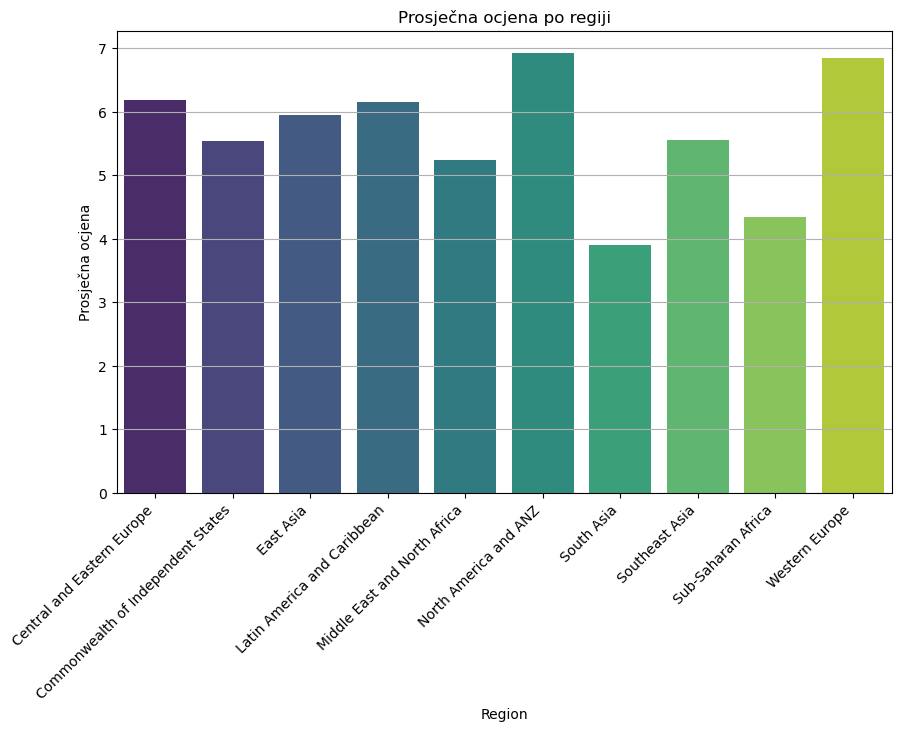

In [133]:
regional_avg = df_baza.groupby('Regija')[['Ocjena srece'] + pollutants].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Regija', y='Ocjena srece', hue='Regija', data=regional_avg, palette='viridis', legend=False)
plt.title('Prosječna ocjena po regiji')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Prosječna ocjena')
plt.xlabel('Region')
plt.grid(axis='y')
plt.show()

# Graf 4

Ovaj graf prikazuje prosječnu zagađenost svih država u pojedinoj regiji, po ovom grafu istočna azija bi trebala bit najzagađenija ali po ocjeni sreće se nalazi na dosta visokoj poziciji , ali s druge strane južna azija ima najmanju prosječnu ocjenu sreće ali isto i najmanje zagađenosti u tom trenutku.

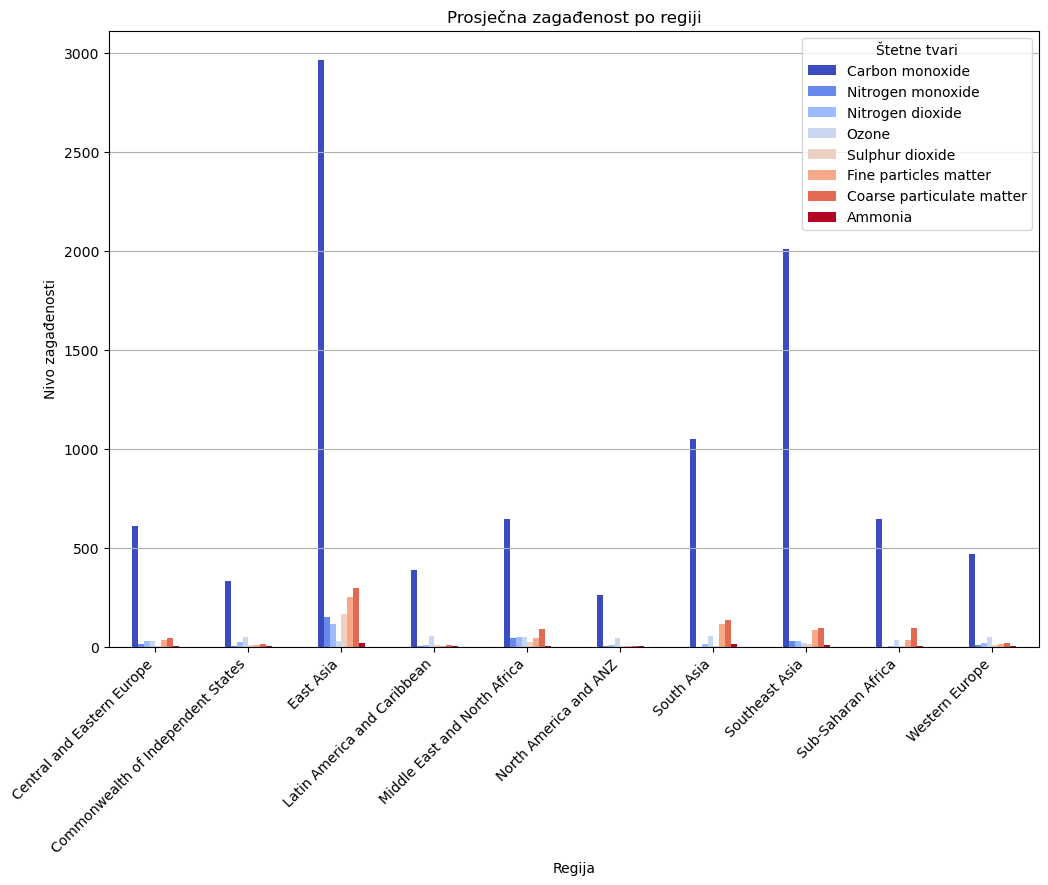

In [139]:
regional_avg.set_index('Regija')[pollutants].plot(kind='bar', figsize=(12, 8), colormap='coolwarm')
plt.title('Prosječna zagađenost po regiji')
plt.ylabel('Nivo zagađenosti')
plt.xlabel('Regija')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Štetne tvari')
plt.grid(axis='y')
plt.show()

# Graf 5

Ovjde možemo vidjeti koje se države smatraju najsretnijima i graf prikazuje ocjenu od najveće prema najmanjoj

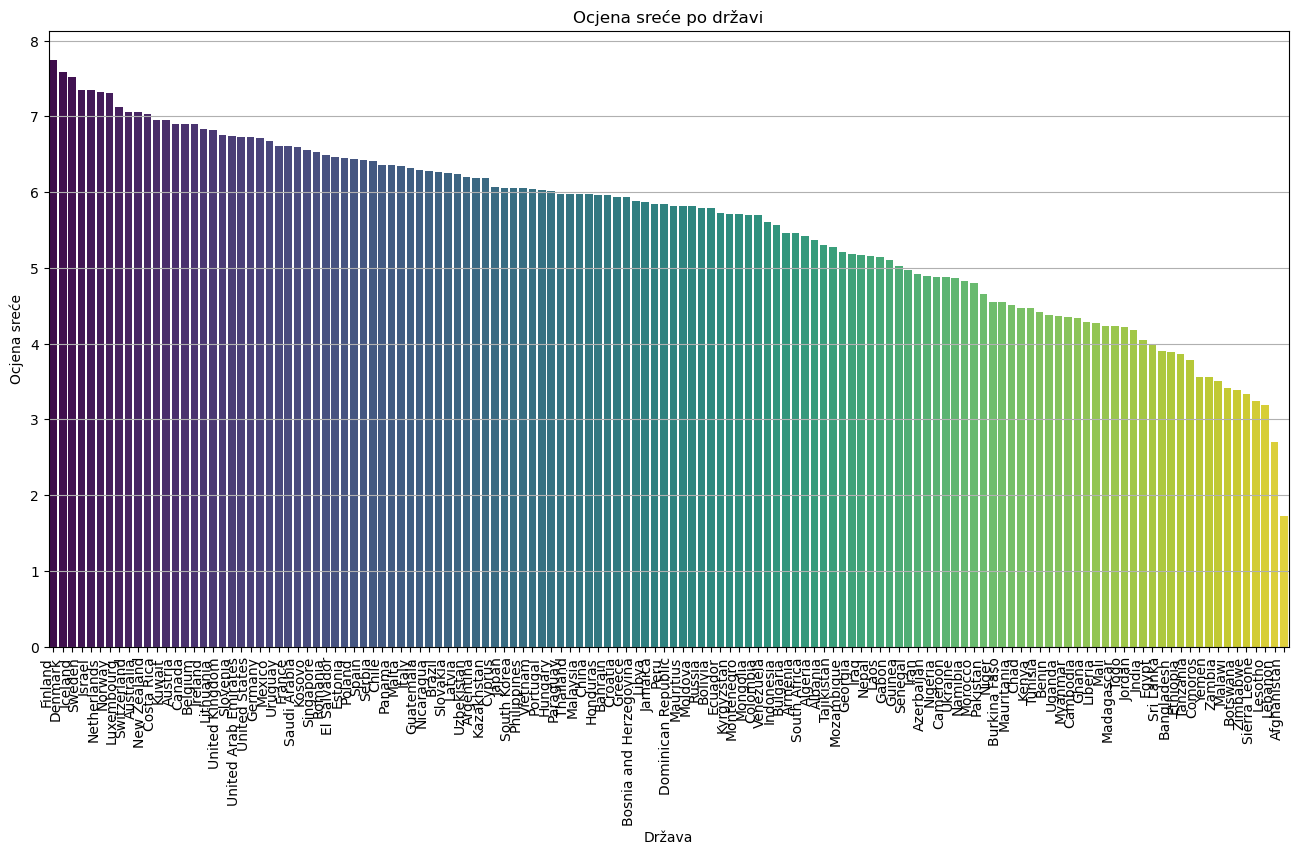

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

df_sortiran = df_baza.sort_values(by='Ocjena srece', ascending=False)

plt.figure(figsize=(16, 8))
sns.barplot(x='Drzava', y='Ocjena srece', hue='Drzava', data=df_sortiran, palette='viridis', legend=False)
plt.title('Ocjena sreće po državi')
plt.xticks(rotation=90, ha='right') 
plt.ylabel('Ocjena sreće')
plt.xlabel('Država')
plt.grid(axis='y')
plt.show()


# Graf 6

Kako bi najbolje prikazao cilj ovog projekta uzeo sam 10 najsretnijih zemalja i 10 najmanje sretnih zemalja i usporedio njihovu ocjenu sreće sa štetnim tvarima u zraku. Prema grafovima ima dosta sličnosti ali je premalo podataka da bi se sa sigurnošću moglo reći da štetne tvari imaju veliki utjecaj u samoj sreći stanovnika tih država.

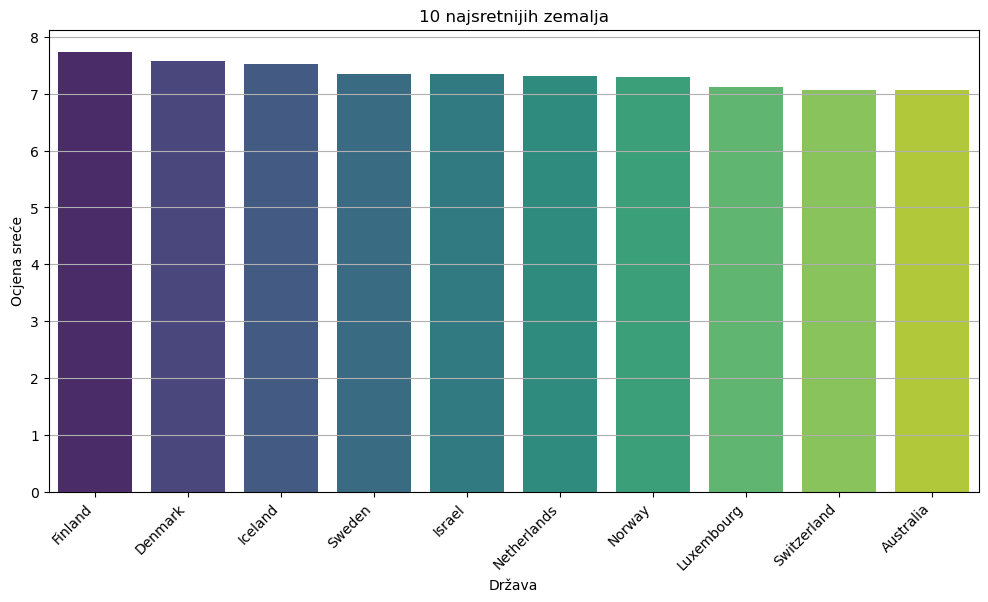

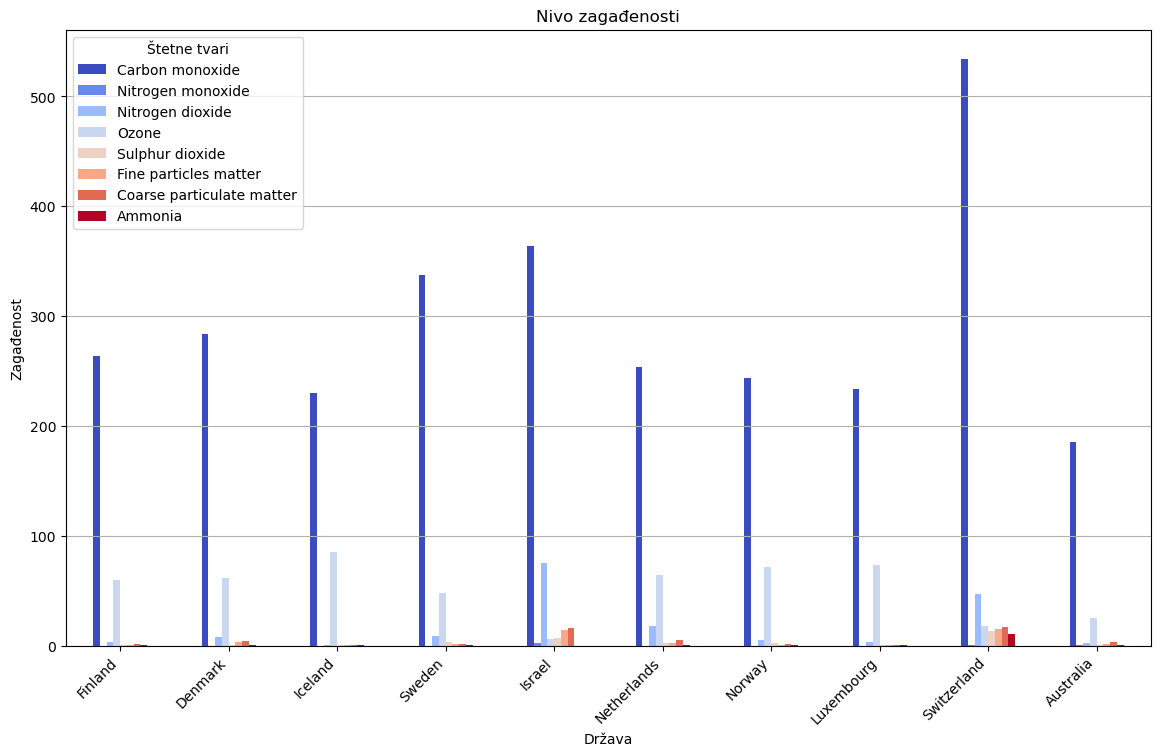

In [159]:
najvise = df_baza.nlargest(10, 'Ocjena srece')

plt.figure(figsize=(12, 6))
sns.barplot(x='Drzava', y='Ocjena srece', hue='Drzava', data=najvise, palette='viridis', legend=False)
plt.title('10 najsretnijih zemalja')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Ocjena sreće')
plt.xlabel('Država')
plt.grid(axis='y')
plt.show()

pollutants = ['Carbon monoxide', 'Nitrogen monoxide', 'Nitrogen dioxide', 
              'Ozone', 'Sulphur dioxide', 'Fine particles matter', 
              'Coarse particulate matter', 'Ammonia']

najvise.set_index('Drzava')[pollutants].plot(kind='bar', figsize=(14, 8), colormap='coolwarm')
plt.title('Nivo zagađenosti')
plt.ylabel('Zagađenost')
plt.xlabel('Država')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Štetne tvari')
plt.grid(axis='y')
plt.show()


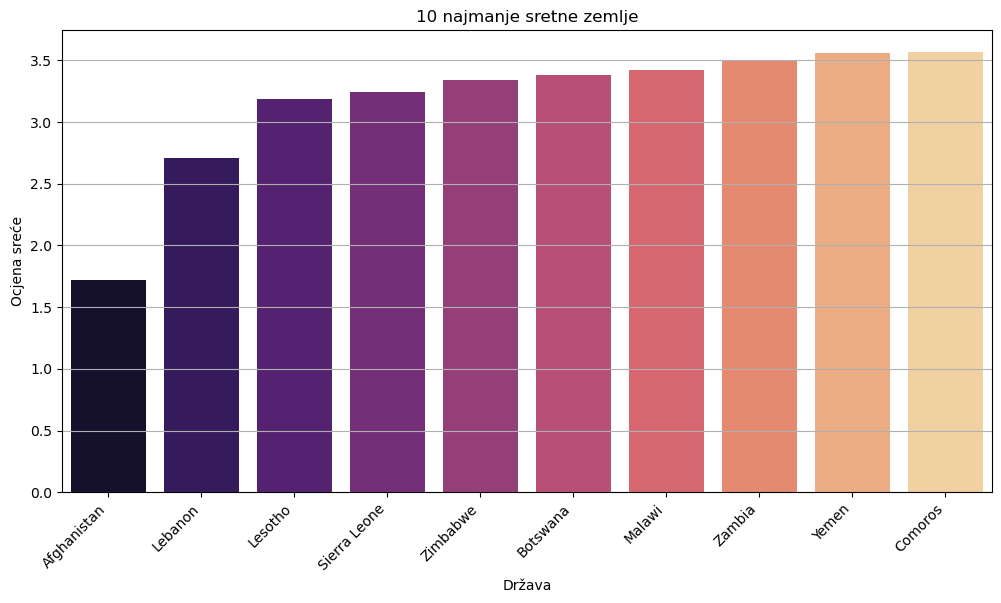

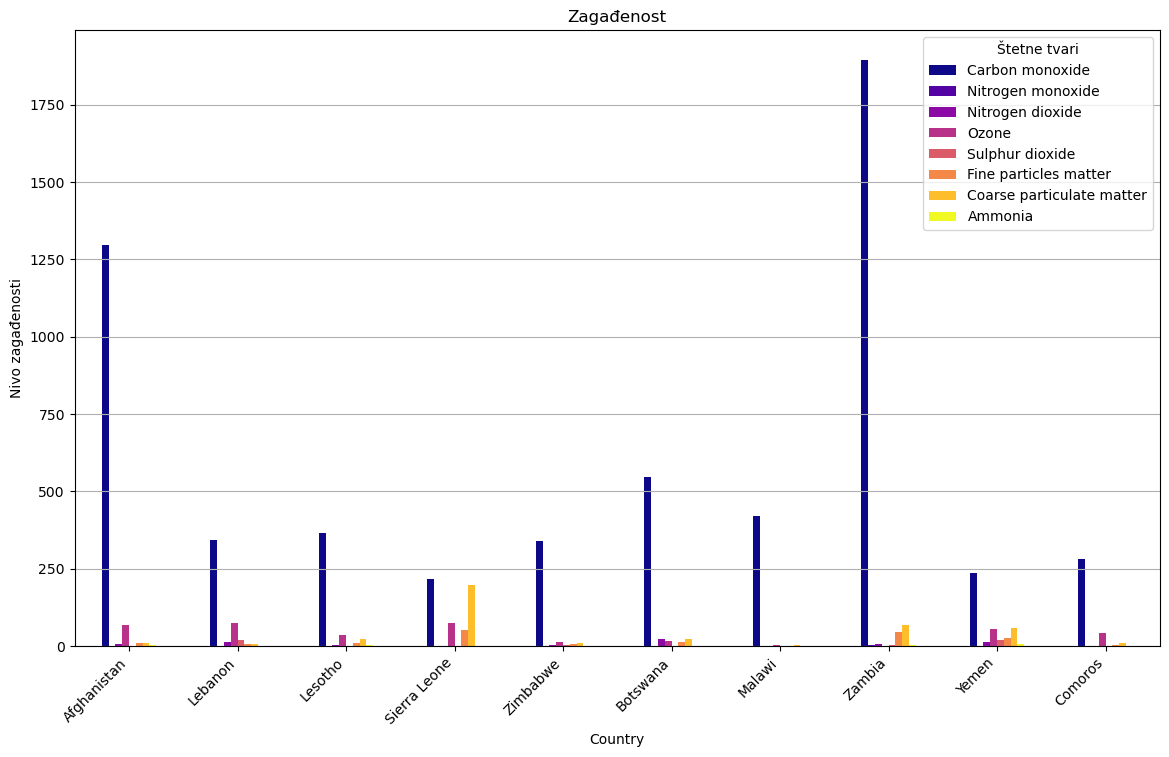

In [162]:
najmanje = df_baza.nsmallest(10, 'Ocjena srece')

plt.figure(figsize=(12, 6))
sns.barplot(x='Drzava', y='Ocjena srece', hue='Drzava', data=najmanje, palette='magma', legend=False)
plt.title('10 najmanje sretne zemlje')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Ocjena sreće')
plt.xlabel('Država')
plt.grid(axis='y')
plt.show()

pollutants = ['Carbon monoxide', 'Nitrogen monoxide', 'Nitrogen dioxide', 
              'Ozone', 'Sulphur dioxide', 'Fine particles matter', 
              'Coarse particulate matter', 'Ammonia']

najmanje.set_index('Drzava')[pollutants].plot(kind='bar', figsize=(14, 8), colormap='plasma')
plt.title('Zagađenost')
plt.ylabel('Nivo zagađenosti')
plt.xlabel('Country')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Štetne tvari')
plt.grid(axis='y')
plt.show()
